In [348]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [349]:
import sys
sys.path.append('/home/hice1/asubramanian91/scratch/git/VLM-Debiasing-Project/scripts')

In [350]:
%autoreload 2
import pandas as pd
import numpy as np
import os
import model as m
import torch
import torch.nn as nn
import torch.optim as optim
import loaders
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [351]:
from fairlearn.adversarial import AdversarialFairnessClassifier

In [352]:
# Gradient Reversal Layer
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Reverse the gradient and scale it by alpha
        return grad_output.neg().mul(ctx.alpha), None

def grad_reverse(x, alpha=1.0):
    return GradientReversalFunction.apply(x, alpha)

# Adversary Model for Gender (Binary)
class GenderAdversary(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(GenderAdversary, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # single output for binary classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # probabilities in [0,1]
        return x



In [353]:
# Main model with integrated adversarial training
class DeepConvLSTMWithAdversary(nn.Module):
    def __init__(self, input_channels, conv_channels, lstm_hidden_size, lstm_layers, output_size, dropout=0.5):
        super(DeepConvLSTMWithAdversary, self).__init__()
        
        # Feature extractor
        self.conv1 = nn.Conv1d(input_channels, conv_channels, kernel_size=9, stride=1, padding=2)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=9, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.lstm = nn.LSTM(input_size=conv_channels, 
                            hidden_size=lstm_hidden_size, 
                            num_layers=lstm_layers, 
                            batch_first=True, 
                            dropout=dropout)
        
        self.fc_task = nn.Linear(lstm_hidden_size, output_size)
        
        # Adversary for gender prediction
        self.adversary = GenderAdversary(lstm_hidden_size, hidden_size=64)
        
        # Store alpha and lambda as attributes for flexible tuning
        self.alpha = 3.0   # start with no adversary pressure
        self.lambda_adv = 0.75  # weighting factor for adversary loss

    def forward(self, x):
        # Forward through feature extractor
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, (h_n, c_n) = self.lstm(x)
        feat = x[:, -1, :]  # feature vector
        
        # Main task output
        task_out = self.fc_task(feat)
        
        # Gradient reversal for adversary
        reversed_feat = grad_reverse(feat, alpha=self.alpha)
        adv_out = self.adversary(reversed_feat)
        
        return task_out, adv_out


In [354]:
class PatientAudioDatasetCSV(Dataset):
    def __init__(self, dataframe, input_column, label_column=None, gender_column=None, normalize=True):
        """
        Args:
            dataframe: DataFrame containing file paths, labels, and gender.
            input_column: Column name containing paths to the npy files with embeddings.
            label_column: Column name containing main labels (PTSD_label).
            gender_column: Column name containing sensitive attribute (gender).
            normalize: Whether to normalize the data (0-1 scaling or Z-score).
        """
        self.dataframe = dataframe
        self.input_column = input_column
        self.label_column = label_column
        self.gender_column = gender_column
        self.normalize = normalize

        if self.normalize:
            self.mean, self.std = self._compute_normalization_stats()
    
    def _compute_normalization_stats(self):
        """Compute mean and std across all data in the provided split."""
        all_data = []
        for path in self.dataframe[self.input_column]:
            audio_data = np.load(path, allow_pickle=True)
            all_data.append(audio_data)
        all_data = np.concatenate(all_data, axis=0)
        return all_data.mean(axis=0), all_data.std(axis=0)

    def _normalize(self, data):
        """Normalize data using computed mean and std."""
        return (data - self.mean) / (self.std + 1e-8)  # to avoid div by zero

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_path = row[self.input_column]
        audio_data = np.load(audio_path, allow_pickle=True).astype(np.float32)

        if self.normalize:
            audio_data = self._normalize(audio_data)

        audio_tensor = torch.tensor(audio_data)

        # If label_column and gender_column provided, return all three
        if self.label_column and self.gender_column:
            label = torch.tensor(row[self.label_column], dtype=torch.float32)
            gender_label = torch.tensor(row[self.gender_column], dtype=torch.float32)
            return audio_tensor, label, gender_label
        elif self.label_column:
            label = torch.tensor(row[self.label_column], dtype=torch.float32)
            return audio_tensor, label
        else:
            return audio_tensor


In [355]:
features_csv = pd.read_csv("/home/hice1/asubramanian91/scratch/e-daic/data/e-daic/data_paths.csv")
features_csv = features_csv.dropna()
features_csv = features_csv[features_csv["gender"] != "unknown"]
gender_map = {"male": 0, "female": 1}
features_csv["gender"] = features_csv["gender"].map(gender_map)
print(features_csv["gender"].isna().sum()) 
print(features_csv["gender"].unique())

0
[1 0]


In [356]:
features_csv = features_csv.sample(frac=1, random_state=99).reset_index(drop=True)

In [357]:
input_column = 'audio'
label_column = 'PTSD_label'
gender_column = "gender"

train_dataset = PatientAudioDatasetCSV(
    features_csv[features_csv["split"]=="train"], 
    input_column=input_column, 
    label_column=label_column, 
    gender_column = gender_column,
    normalize=True
)

dev_dataset = PatientAudioDatasetCSV(
    features_csv[features_csv["split"]=="dev"], 
    input_column=input_column, 
    label_column=label_column,
    gender_column=gender_column,
    normalize=True
)

test_dataset = PatientAudioDatasetCSV(
    features_csv[features_csv["split"]=="test"], 
    input_column=input_column, 
    label_column=label_column,
    gender_column=gender_column,
    normalize=True
)

In [358]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for batch_data, batch_label, batch_gender in train_dataloader:
        print(f"Data Shape: {batch_data.shape}, Labels Shape: {batch_label.shape}, Gender Shape: {batch_gender.shape}")

Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4]), Gender Shape: torch.

In [359]:
model = DeepConvLSTMWithAdversary(
    input_channels=768, 
    conv_channels=64, 
    lstm_hidden_size=128, 
    lstm_layers=2, 
    output_size=1, 
    dropout=0.5
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
task_criterion = nn.BCEWithLogitsLoss()
adv_criterion = nn.BCELoss()

In [360]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

719234

In [361]:
learning_rate = 0.001
num_epochs = 20
mix_prob = 0.5
alpha = 1.0
# Define loss function and optimizer
#criterion = RMSLELoss()
 # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [362]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

In [363]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
class_weights = len(labels_torch) / (2.0 * class_counts)

# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[0])  # Weight for positive class
class_weights

tensor([0.7149, 1.6633])

In [364]:
from sklearn.metrics import f1_score
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    model.alpha = min(1.0, epoch / (num_epochs / 2))  # if you're ramping alpha
    running_train_loss = 0.0

    all_train_preds = []
    all_train_labels = []

    for inputs, ptsd_labels, gender_labels in train_dataloader:
        optimizer.zero_grad()
        
        task_out, adv_out = model(inputs)
        
        ptsd_labels = ptsd_labels.unsqueeze(1).float()
        gender_labels = gender_labels.unsqueeze(1).float()
        
        task_loss = task_criterion(task_out, ptsd_labels)
        adv_loss = adv_criterion(adv_out, gender_labels)
        
        loss = task_loss + model.lambda_adv * adv_loss
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        # Compute predictions for training F1
        preds = (torch.sigmoid(task_out) > 0.5).cpu().numpy().flatten()
        all_train_preds.extend(preds)
        all_train_labels.extend(ptsd_labels.cpu().numpy().flatten())
    
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Compute training F1 score
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    all_dev_preds = []
    all_dev_labels = []

    with torch.no_grad():
        for inputs, ptsd_labels, gender_labels in dev_dataloader:
            task_out, adv_out = model(inputs)
            ptsd_labels = ptsd_labels.unsqueeze(1).float()
            loss = task_criterion(task_out, ptsd_labels)
            running_val_loss += loss.item()

            preds = (torch.sigmoid(task_out) > 0.5).cpu().numpy().flatten()
            all_dev_preds.extend(preds)
            all_dev_labels.extend(ptsd_labels.cpu().numpy().flatten())

    avg_val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}, alpha: {model.alpha:.2f}")

Epoch [1/20] - Train Loss: 1.1537, Train F1: 0.6292, Val Loss: 0.6222, Val F1: 0.5646, alpha: 0.00
Epoch [2/20] - Train Loss: 1.1335, Train F1: 0.5757, Val Loss: 0.6181, Val F1: 0.5646, alpha: 0.10
Epoch [3/20] - Train Loss: 1.1406, Train F1: 0.5757, Val Loss: 0.6188, Val F1: 0.5646, alpha: 0.20
Epoch [4/20] - Train Loss: 1.1289, Train F1: 0.5757, Val Loss: 0.6268, Val F1: 0.5646, alpha: 0.30
Epoch [5/20] - Train Loss: 1.1050, Train F1: 0.5757, Val Loss: 0.6139, Val F1: 0.5646, alpha: 0.40
Epoch [6/20] - Train Loss: 1.0822, Train F1: 0.6180, Val Loss: 0.7506, Val F1: 0.5612, alpha: 0.50
Epoch [7/20] - Train Loss: 1.0335, Train F1: 0.6914, Val Loss: 0.6014, Val F1: 0.6738, alpha: 0.60
Epoch [8/20] - Train Loss: 0.9999, Train F1: 0.7546, Val Loss: 0.6294, Val F1: 0.6818, alpha: 0.70
Epoch [9/20] - Train Loss: 0.9568, Train F1: 0.8160, Val Loss: 0.6689, Val F1: 0.6591, alpha: 0.80
Epoch [10/20] - Train Loss: 0.8655, Train F1: 0.8505, Val Loss: 0.9072, Val F1: 0.6243, alpha: 0.90
Epoch [11

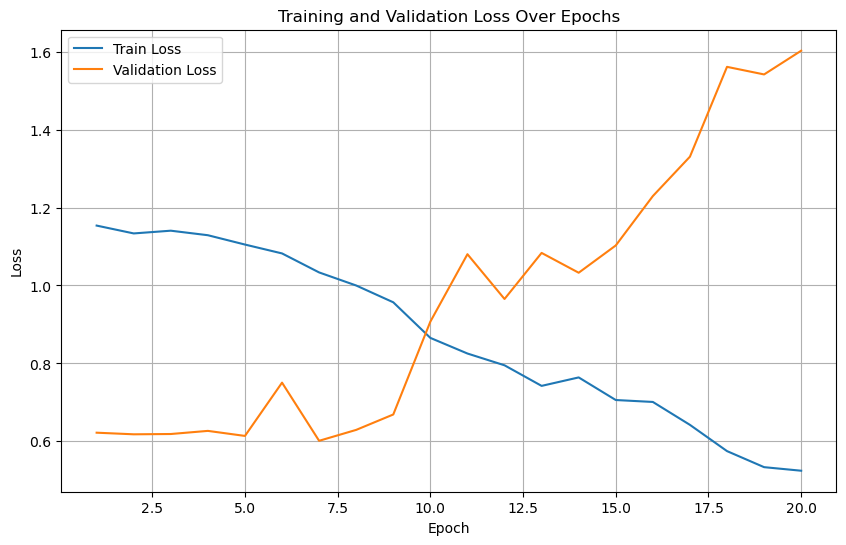

In [365]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [366]:
model.eval()  # Set the model to evaluation mode
all_test_preds = []
all_test_gender = []

with torch.no_grad():
    for inputs, ptsd_labels, gender_labels in test_dataloader:
        # Forward pass
        task_out, adv_out = model(inputs)
        
        # Convert logits to predictions
        preds = (torch.sigmoid(task_out) > 0.5).cpu().numpy().flatten()
        
        # Collect predictions and gender labels
        all_test_preds.extend(preds)
        all_test_gender.extend(gender_labels.cpu().numpy().flatten())

# Convert to numpy arrays
all_test_preds = np.array(all_test_preds)
all_test_gender = np.array(all_test_gender)

y_pred = all_test_preds
y_test = all_test_gender

In [367]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="test"]["gender"], features_csv[features_csv["split"]=="test"]["gender"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

Shape of gender_test: (54,)
Shape of y_test: (54,)
Shape of y_pred: (54,)


In [368]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.08214285714285716


In [369]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)

Selection Rates by Group:
gender
0    0.225000
1    0.142857
Name: selection_rate, dtype: float64


In [370]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

Demographic Parity Ratio: 0.6349206349206349
